In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation

In [ ]:
data = pd.read_csv('/content/training_set.csv')

In [ ]:
X = data.drop('SOURCE', axis=1)
y = data['SOURCE']

In [ ]:
# use one-hot encoding to convert 'string' to numerical values
X = pd.get_dummies(X, columns = ['SEX'], drop_first=True)

# Model Training

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=42)

In [ ]:
dtc = DecisionTreeClassifier(random_state = 42)

dtc.fit(X_train, y_train)

y_train_pred = dtc.predict(X_train)
y_val_pred = dtc.predict(X_val)
y_test_pred = dtc.predict(X_test)

# 報告
print("=== DTC Training Report ===")
print(classification_report(y_train, y_train_pred))

print("=== DTC Validation Report ===")
print(classification_report(y_val, y_val_pred))

print("=== DTC Test Report ===")
print(classification_report(y_test, y_test_pred))

=== DTC Training Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1403
           1       1.00      1.00      1.00       913

    accuracy                           1.00      2316
   macro avg       1.00      1.00      1.00      2316
weighted avg       1.00      1.00      1.00      2316

=== DTC Validation Report ===
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       197
           1       0.62      0.62      0.62       134

    accuracy                           0.69       331
   macro avg       0.68      0.68      0.68       331
weighted avg       0.69      0.69      0.69       331

=== DTC Test Report ===
              precision    recall  f1-score   support

           0       0.69      0.70      0.70       392
           1       0.56      0.55      0.55       270

    accuracy                           0.64       662
   macro avg       0.62      0.62      0.62   

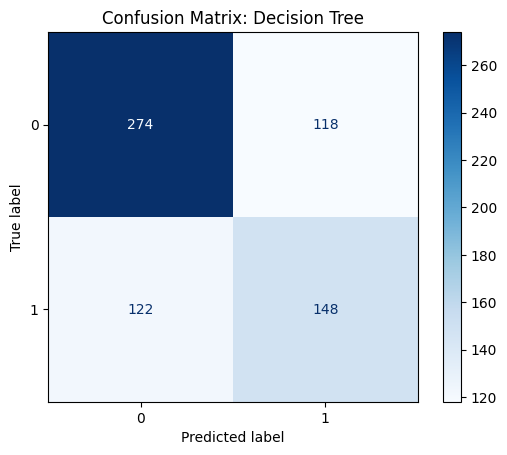

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix: Decision Tree")
plt.show()

# Tune the parameters

In [ ]:
param_grid = {
    'max_depth': [3, 5, 10, 15, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],      # Minimum samples required at a leaf node
    'criterion': ['gini', 'entropy']     # The function to measure the quality of a split
}

In [ ]:
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,              # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,         # Use all available cores
    verbose=1
)

grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best cross-validation score: 0.7202092798093392


In [ ]:
# Evaluate the model on validation set
best_dt = grid_search.best_estimator_
val_predictions = best_dt.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation accuracy: {val_accuracy:.4f}")

# Evaluate on test set
test_predictions = best_dt.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test accuracy: {test_accuracy:.4f}")
print("\nClassification Report on Test Set:")
print(classification_report(y_test, test_predictions))

Validation accuracy: 0.7553
Test accuracy: 0.7009

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77       392
           1       0.67      0.51      0.58       270

    accuracy                           0.70       662
   macro avg       0.69      0.67      0.68       662
weighted avg       0.70      0.70      0.69       662



**Tuning Result**

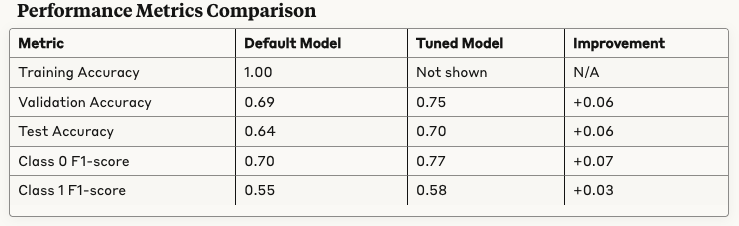

From the result, we can see that the tuned decision tree model has improved by 6% in both validation and test accuracy. Besides, we can observe that the tuning process prevents the model from overfitting. The default decision trees achieved 100% accuracy on the training dataset but performed poorly on validation and test datasets, which is a classic sign of overfitting. The tuned model significantly reduced this overfitting gap.

1. Parameters analysis :
* Max depth: This limits tree complexity, preventing overfitting. The default setting is None, which means the tree can grow without limit, which is why the training accuracy can reach a perfect score but poor test performance before tuning.

* min_samples_split: Increasing this from 2 (Default) means nodes only split if they have at least 10 samples, creating more robust splits less affected by noise.

* min_samples_leaf: The default setting is 1, which allows leaf nodes with just 1 sample, leading to very specific rules for individual data points. The tuning process increases to 2, which makes the tree more balanced and prevents overfitting.

2. Conclusion: Looking at my initial results, I noticed the default decision tree was clearly overfitted - perfect training accuracy (1.00) but only 0.64 on test data.
To fix this, I focused on tuning parameters that control tree complexity: max_depth, min_samples_split, min_samples_leaf, and it has improved overall. In conclusion, I viewed these three parameters as the most influential parameters in this case.


# Feature Importance

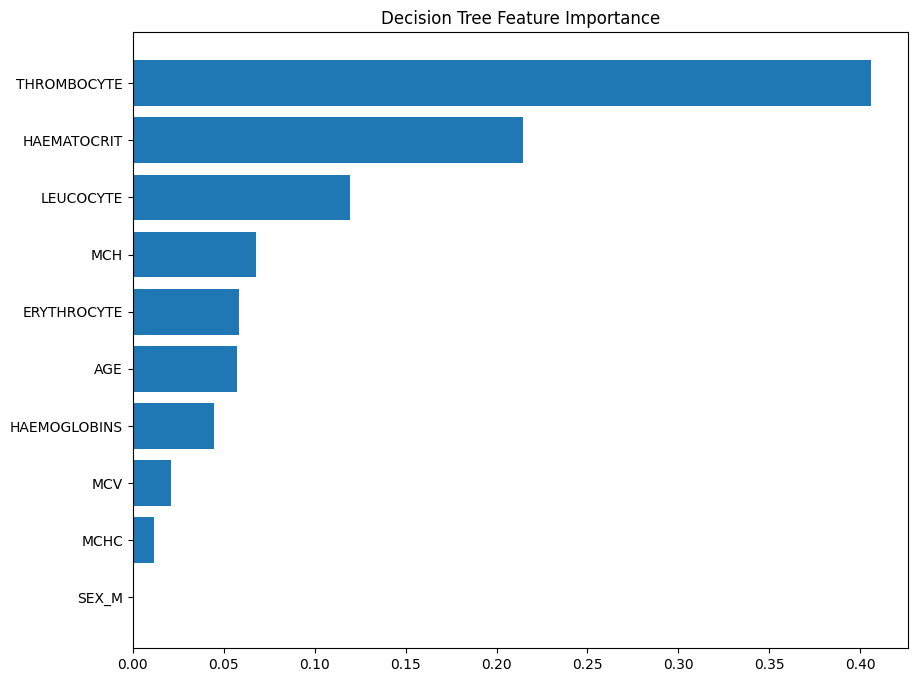

In [ ]:
feature_importance = best_dt.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title('Decision Tree Feature Importance')
plt.show()

In [ ]:
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
4,THROMBOCYTE,0.405913
0,HAEMATOCRIT,0.214488
3,LEUCOCYTE,0.119505
5,MCH,0.067753
2,ERYTHROCYTE,0.058353
8,AGE,0.057310
1,HAEMOGLOBINS,0.044402
7,MCV,0.020910
6,MCHC,0.011365
9,SEX_M,0.000000


In [ ]:
threshold = 0.05

selected_features = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()

In [ ]:
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

best_dt.fit(X_train_selected, y_train)
selected_test_preds = best_dt.predict(X_test_selected)
selected_test_acc = accuracy_score(y_test, selected_test_preds)

print("\n--- Model with Selected Features Performance ---")
print(f"Test Accuracy: {selected_test_acc:.4f}")
print("\nClassification Report (Feature-Selected Model):")
print(classification_report(y_test, selected_test_preds))


--- Model with Selected Features Performance ---
Test Accuracy: 0.7069

Classification Report (Feature-Selected Model):
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       392
           1       0.70      0.50      0.58       270

    accuracy                           0.71       662
   macro avg       0.70      0.67      0.68       662
weighted avg       0.71      0.71      0.70       662



**Feature Selection Report**

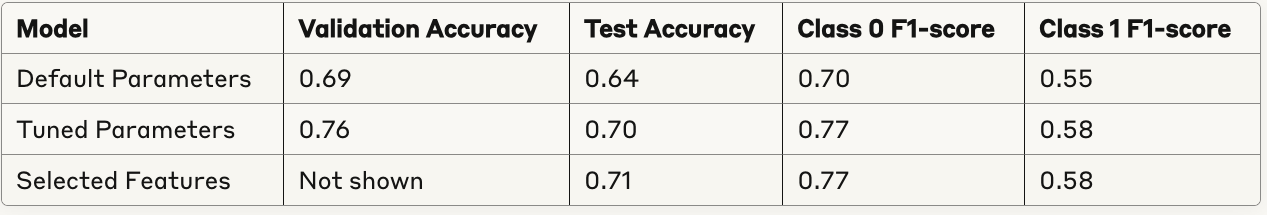

I trained the selected features (threshold = 0.05) with the optimized model (the model with tuned parameters). Since there are only 10 features, I set the threshold to 0.05 to extract features. The model with selected features improves slightly from 0.70 to 0.71 in test accuracy. Parameter tuning made the most significant difference, significantly improving the model's performance. Unlike the gradient boosting model, feature selection did provide a slight improvement. The combination of parameter tuning and feature selection delivered the best overall performance.